In [1]:
import os
import pandas as pd
from google.colab import drive

# Mount Google Drive if your dataset is stored there
drive.mount('/content/drive')

# Define the dataset path
# If the dataset is uploaded directly to Colab, set the path accordingly
dataset_path = "/content/drive/MyDrive/Alziemhers disease /Alzheimer_s Dataset/train"  # Update the path

# Define a dictionary to store file paths and labels
data = {"FilePath": [], "Label": []}

# Iterate through the folders and assign labels
for label, folder in enumerate(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if filename.endswith((".jpg", ".png", ".jpeg")):  # Filter image files
                data["FilePath"].append(file_path)
                data["Label"].append(folder)

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_path = "/content/brain_dataset_labels.csv"
df.to_csv(csv_path, index=False)

print(f"CSV file saved at {csv_path}")


Mounted at /content/drive
CSV file saved at /content/brain_dataset_labels.csv


In [2]:
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
csv_path = "/content/brain_dataset_labels.csv"  # Update this if needed
df = pd.read_csv(csv_path)

# Encode the labels
label_encoder = LabelEncoder()
df['EncodedLabel'] = label_encoder.fit_transform(df['Label'])

# Display the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)

# Save the updated DataFrame to a new CSV file
encoded_csv_path = "/content/brain_dataset_labels_encoded.csv"
df.to_csv(encoded_csv_path, index=False)

print(f"Encoded CSV file saved at {encoded_csv_path}")


Label Encoding Mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Encoded CSV file saved at /content/brain_dataset_labels_encoded.csv


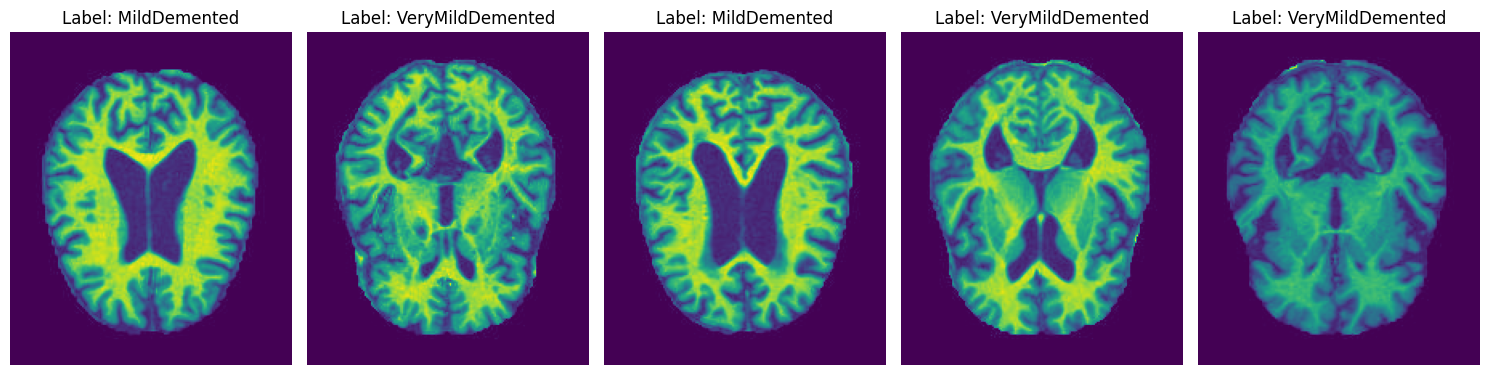

In [3]:
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "/content/brain_dataset_labels_encoded.csv"  # Update this to your file path
df = pd.read_csv(csv_path)

def load_random_images(dataframe, count=5):
    # Select 'count' random rows
    random_rows = dataframe.sample(n=count)

    # Plot each image
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(random_rows.iterrows()):
        file_path = row['FilePath']
        label = row['Label']

        # Load and plot the image
        image = Image.open(file_path)
        plt.subplot(1, count, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and display 5 random images
load_random_images(df, count=5)



In [ ]:
from PIL import Image
import pandas as pd

# Assuming your DataFrame with file paths is named 'df'
# and the column containing file paths is 'FilePath'

# Initialize a list to store image sizes
image_sizes = []

# Iterate through all image file paths in the DataFrame
for file_path in df['FilePath']:
    try:
        # Open the image and get its size (width, height)
        with Image.open(file_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")

# Create a DataFrame to analyze the sizes
size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Display statistics about the image sizes
print("Image Size Distribution:")
print(size_df.describe())  # Summary statistics (mean, min, max, etc.)

# Optionally, find the most common sizes
common_sizes = size_df.value_counts().reset_index(name='Count')
print("\nMost Common Image Sizes:")
print(common_sizes)


Image Size Distribution:
        Width  Height
count  5291.0  5291.0
mean    176.0   208.0
std       0.0     0.0
min     176.0   208.0
25%     176.0   208.0
50%     176.0   208.0
75%     176.0   208.0
max     176.0   208.0

Most Common Image Sizes:
   Width  Height  Count
0    176     208   5291


In [3]:
import pandas as pd

# Assuming you have a DataFrame with a 'EncodedLabel' or 'Label' column
csv_path = "/content/brain_dataset_labels_encoded.csv"
df = pd.read_csv(csv_path)

# Count occurrences of each class
class_counts = df['EncodedLabel'].value_counts()  # Replace 'EncodedLabel' with 'Label' if needed
print("Number of images per class:")
print(class_counts)


Number of images per class:
EncodedLabel
2    2660
3    1852
0     727
1      52
Name: count, dtype: int64


In [4]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np  # Import numpy for array operations

# Load your DataFrame with paths and labels
df = pd.read_csv("/content/brain_dataset_labels_encoded.csv")  # Replace with your path

# Define the image size and batch size
img_size = (128, 128)  # Example image size (adjust as needed)
batch_size = 32  # Adjust according to your needs

# Prepare your image data and labels
X_data = df['FilePath'].values  # List of image file paths
y_data = df['EncodedLabel'].values  # Your labels (already encoded)

# Apply SMOTE to balance the classes, but only on the labels
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Resample the labels and create a mapping to the original file paths
_, y_resampled = smote.fit_resample(np.arange(len(y_data)).reshape(-1, 1), y_data) # Use indices for SMOTE
# Create a dictionary to map the file paths to their original indices
file_path_mapping = {i: path for i, path in enumerate(X_data)}
# Get file paths for resampled labels by index
X_resampled = [file_path_mapping[i] for i in smote.fit_resample(np.arange(len(y_data)).reshape(-1, 1), y_data)[0].flatten()]

# Update your DataFrame with the resampled data
df_resampled = pd.DataFrame({'File_Path': X_resampled, 'labels': y_resampled.astype(str)})

# Now, set up your ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=30,  # Example augmentation parameters
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the data generator using flow_from_dataframe
data_generator = datagen.flow_from_dataframe(
    df_resampled,          # Use the resampled dataframe
    x_col='File_Path',    # Column containing image file paths
    y_col='labels',        # Column containing labels
    target_size=img_size,  # Resize images to the target size
    batch_size=batch_size, # Batch size
    color_mode='rgb',      # Color mode (can be 'rgb' or 'grayscale')
    class_mode='categorical', # Assuming you are working with categorical labels
    shuffle=True           # Shuffle the data
)

# The generator can now be used for training

Found 7899 validated image filenames belonging to 4 classes.


In [8]:
# Assuming your DataFrame is named 'df' and the label column is 'EncodedLabel'
# If you're using string labels, check their corresponding encoded values

# Display unique labels and their encoded values
print("Unique labels and their encoded values:")
print(df['Label'].value_counts())  # This will show the counts of original string labels
print("\nEncoded label mappings:")

# If labels are already encoded numerically, display unique encoded values
encoded_labels = df['EncodedLabel'].value_counts()  # Count of encoded labels
print(encoded_labels)

# Display the mapping between original labels and encoded labels
# If the labels were encoded using LabelEncoder, print the mapping
if 'EncodedLabel' in df.columns:
    label_mapping = {label: idx for idx, label in enumerate(df['Label'].unique())}
    print("\nLabel to Encoded Label Mapping:")
    print(label_mapping)


Unique labels and their encoded values:
Label
NonDemented         2660
VeryMildDemented    1852
MildDemented         727
ModerateDemented      52
Name: count, dtype: int64

Encoded label mappings:
EncodedLabel
2    2660
3    1852
0     727
1      52
Name: count, dtype: int64

Label to Encoded Label Mapping:
{'VeryMildDemented': 0, 'NonDemented': 1, 'ModerateDemented': 2, 'MildDemented': 3}


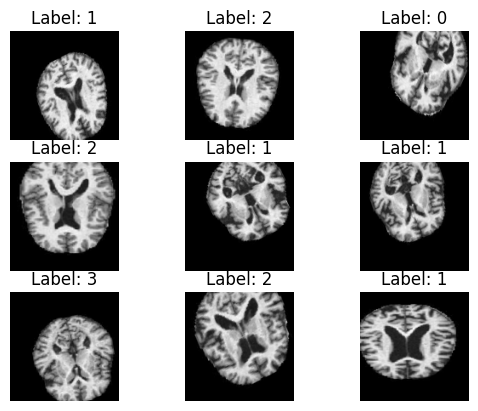

In [5]:
import matplotlib.pyplot as plt

# Fetch one batch from the data generator
images, labels = next(data_generator)

# Plot a few images from the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].argmax()}")
    plt.axis('off')
plt.show()


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')  # Assuming 4 classes
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
history = model.fit(
    data_generator,
    epochs=20,  # Number of training epochs
    steps_per_epoch=len(data_generator),
    validation_data=data_generator,  # Use validation generator if available
    validation_steps=10  # Example value
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


247/247 ━━━━━━━━━━━━━━━━━━━━ 2330s 9s/step - accuracy: 0.3329 - loss: 1.5324 - val_accuracy: 0.3719 - val_loss: 1.2957
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3063 - val_loss: 1.3158
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 108s 296ms/step - accuracy: 0.3362 - loss: 1.3011 - val_accuracy: 0.3187 - val_loss: 1.3294
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3219 - val_loss: 1.3007
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 75s 295ms/step - accuracy: 0.3216 - loss: 1.3702 - val_accuracy: 0.3281 - val_loss: 1.3458
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3031 - val_loss: 1.3502
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 78s 288ms/step - accuracy: 0.3321 - loss: 1.3152 - val_accuracy: 0.2781 - val_loss: 1.3166
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3219 - val_loss: 1.3077
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 74s 290ms/step - accuracy: 0.3

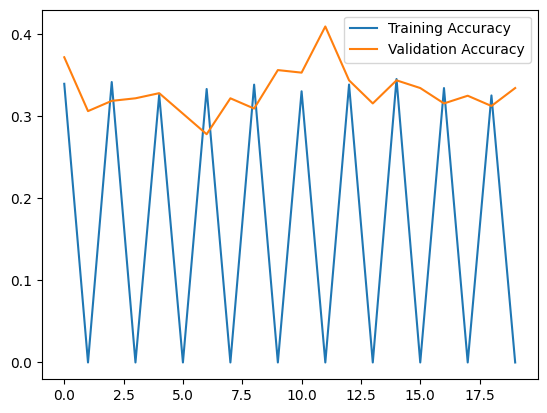

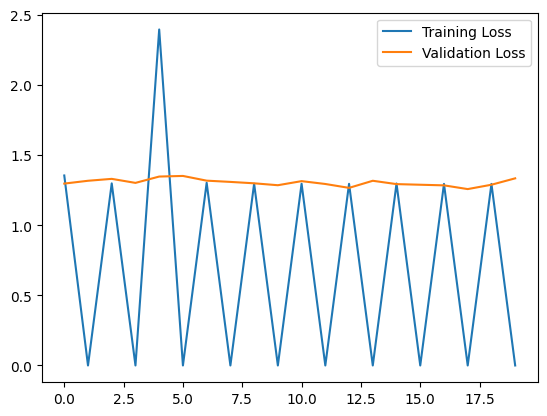

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
